# 0 - To start

## Some libraries to load

In [2]:
import numpy as np
from math import pi, gcd
import pandas as pd
try:
    from qiskit import *
    from matplotlib.pyplot import plot,show
except:
    ! python -m pip install matplotlib pylatexenc
    ! python -m pip install qiskit
from qiskit.circuit import *
from qiskit.extensions import *
from qiskit.circuit.library import *
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.quantum_info.operators import Operator
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from scipy import optimize
from matplotlib.pyplot import plot,show
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

## A few useful functions

- `nat2bl` : from a natural number to a list of `0` and `1` (low-end bit on the right)
- `nat2bs` : from a natural number to a string such as `"010010011"`
- `bl2bs` : from a list to a string
- ... and all of the functions in the other direction.

In [2]:
def nat2bl(pad,n):
    if n == 0 :
        return [0 for i in range(pad)]
    elif n % 2 == 1:
        r = nat2bl(pad-1,(n-1)//2)
        r.append(1)
        return r
    else:
        r = nat2bl(pad-1,n//2)
        r.append(0)
        return r

for i in range(16):
    print(nat2bl(5,i))

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 1, 1]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 1, 1, 1]
[0, 1, 0, 0, 0]
[0, 1, 0, 0, 1]
[0, 1, 0, 1, 0]
[0, 1, 0, 1, 1]
[0, 1, 1, 0, 0]
[0, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 1, 1, 1, 1]


In [3]:
def bl2nat(s):
    if len(s) == 0:
        return 0
    else:
        a = s.pop()
        return (a + 2*bl2nat(s))

def bl2bs(l):
    if len(l) == 0:
        return ""
    else:
        a = l.pop()
        return (bl2bs(l) + str(a))

def nat2bs(pad,i):
    return bl2bs(nat2bl(pad,i))

def bs2bl(s):
    l = []
    for i in range(len(s)):
        l.append(int(s[i]))
    return l

def bs2nat(s):
    return bl2nat(bs2bl(s))


print(nat2bl(10,17))
print(bs2nat("0011010"))

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
26


## Small practice

To start, check that when we measure $\frac1{\sqrt2}(|000\rangle+|111\rangle)$ we indeed get 000 and 111 about the same number of times. 

In [3]:
# Generating the circuit

q = QuantumRegister(3)   # We need 3 qubits..
c = ClassicalRegister(3) # ... and 3 bits to store the results
qc = QuantumCircuit(q,c) # the circuit !

# TODO : realize the circ that build 1/sqrt(2)(|000>+|111>)
qc.h(q[0])
qc.cnot(q[0], q[1])
qc.cnot(q[0], q[2])
# TODO : measure and check
qc.measure(q, c)

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1024)
res = dict(job.result().get_counts(qc))
res


{'000': 473, '111': 551}

In [4]:
qc.draw()

┌───┐             ┌─┐   
q0_0: ┤ H ├──■────■─────┤M├───
      └───┘┌─┴─┐  │  ┌─┐└╥┘   
q0_1: ─────┤ X ├──┼──┤M├─╫────
           └───┘┌─┴─┐└╥┘ ║ ┌─┐
q0_2: ──────────┤ X ├─╫──╫─┤M├
                └───┘ ║  ║ └╥┘
c0_0: ════════════════╬══╩══╬═
                      ║     ║ 
c0_1: ════════════════╩═════╬═
                            ║ 
c0_2: ══════════════════════╩═

In [8]:
qc.decompose().draw()

┌─────────┐             ┌─┐   
q0_0: ┤ U2(0,π) ├──■────■─────┤M├───
      └─────────┘┌─┴─┐  │  ┌─┐└╥┘   
q0_1: ───────────┤ X ├──┼──┤M├─╫────
                 └───┘┌─┴─┐└╥┘ ║ ┌─┐
q0_2: ────────────────┤ X ├─╫──╫─┤M├
                      └───┘ ║  ║ └╥┘
c0_0: ══════════════════════╬══╩══╬═
                            ║     ║ 
c0_1: ══════════════════════╩═════╬═
                                  ║ 
c0_2: ════════════════════════════╩═

If everything works, you are ready to start.

# 1 - Introduction

In this lab session we are going to code the heart of Shor's algorithm: the circuit making it possible to find the period of the function

$$
x \mapsto a^x mod N.
$$

We then need first to code QPE, then the oracle computing the multiplication modulo, then combined everything.

**Objective** : Only to convince yourself that the number we are looking for can be recovered from the final distribution.

Let's go.

# 2 - QPE

We've seen the QPE algorithm in the course, and you checked it worked with 3 qubits. Here we are going to implement it with the following unitary:

In [6]:
U = UnitaryGate(
    Operator([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,np.exp(pi*2j*(6/8))]]), label="U")

## Questions 

###  Q 2.1 Math questions

* What is doing this operator ? (`2j` is in Python the complex number $2\cdot i$)
> To change phase
* On how many qubits does it act ?
> 2
* What are its eigenvalues/eigenvectors ?
> eigenvalues could be 1 and exp(pi*2j*(6/8))]])
eigenvectors could be |00>, |01>, |10>, |11>

* For each eigenvector, what should QPE return with 3 bits of precisions, as seen in the course ?
> x1, x2, x3, x4

### Q 2.2 Implementing QPE

Below a template to fill in for
- realize QPE with 3 bits of precision.
- on the eigenvector of non-trivial eigenvalue

We initialized a quantum circuit with 3 registers:
 - `eig` for storing the eigenvalues
 - `phi` for storing the eigenvector
 - `ceig` for storing the result of the measurement of the eigenvalue-register.
 
Note that we only need to measure the eigenvalues!

What you will need:
 - `QFT(size)` build for you a QFT on `size` qubits.
 - `U.control()` for controlling a gate `U`. The control qubit should be placed first in the list of wires.
 - `U.inverse()` for the inverse of the gate `U`.
 - `U.power(n)` add `p` times `U` on the circuit.
 - `qc.append(U, list_of_qubits)` applies the gate `U` on the list of qubits.
 - Beware : `phi` (for instance) is not a list but a register. So if you want to concatenate it with something else, you first have to make a list out of it with `list(phi)`.

In [15]:
size_eig = 3
size_phi = 2

eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig,phi,ceig)



# To fill in
qc.h(eig[0])
qc.h(eig[1])
qc.h(eig[2])

qc.x(phi[0])
qc.x(phi[1])

# Another way to give eigenvector to solve problem
# qc.h(phi[0])
# qc.cnot(phi[0], phi[1])


# C-U, C-U^2, C-U^4
qc.barrier()
qc.append(U.control(), [eig[0], phi[0], phi[1]])
qc.append(U.power(2).control(), [eig[1], phi[0], phi[1]])
qc.append(U.power(4).control(), [eig[2], phi[0], phi[1]])

qc.append(QFT(num_qubits=3).inverse(), eig)

qc.measure(eig, ceig)

qc.draw()

# First, make sure that the drawing is OK.

┌───┐ ░                                   ┌───────┐┌─┐      
 eig_0: ┤ H ├─░───■───────────────────────────────┤0      ├┤M├──────
        ├───┤ ░   │                               │       │└╥┘┌─┐   
 eig_1: ┤ H ├─░───┼─────────■─────────────────────┤1 IQFT ├─╫─┤M├───
        ├───┤ ░   │         │                     │       │ ║ └╥┘┌─┐
 eig_2: ┤ H ├─░───┼─────────┼─────────────■───────┤2      ├─╫──╫─┤M├
        ├───┤ ░ ┌─┴──┐┌─────┴──────┐┌─────┴──────┐└───────┘ ║  ║ └╥┘
 phi_0: ┤ X ├─░─┤0   ├┤0           ├┤0           ├──────────╫──╫──╫─
        ├───┤ ░ │  U ││  unitary^2 ││  unitary^4 │          ║  ║  ║ 
 phi_1: ┤ X ├─░─┤1   ├┤1           ├┤1           ├──────────╫──╫──╫─
        └───┘ ░ └────┘└────────────┘└────────────┘          ║  ║  ║ 
ceig_0: ════════════════════════════════════════════════════╩══╬══╬═
                                                               ║  ║ 
ceig_1: ═══════════════════════════════════════════════════════╩══╬═
                                                                  ║ 
ceig_2: ══════════════════════════════════════════════════════════╩═

In [16]:
# Then run the backend !

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
job.result().get_counts(qc)

{'110': 1000}

In [33]:
# Answer of question 3, with 4 eigenvalues, 10/16 eigenvector

U = UnitaryGate(
    Operator([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,np.exp(pi*2j*(10/16))]]), label="U")

size_eig = 4
size_phi = 2

eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig,phi,ceig)

# To fill in
qc.h(eig[0])
qc.h(eig[1])
qc.h(eig[2])
qc.h(eig[3])

qc.x(phi[0])
qc.x(phi[1])

# Another way to give eigenvector to solve problem
# qc.h(phi[0])
# qc.cnot(phi[0], phi[1])


# C-U, C-U^2, C-U^4
qc.barrier()
qc.append(U.control(), [eig[0], phi[0], phi[1]])
qc.append(U.power(2).control(), [eig[1], phi[0], phi[1]])
qc.append(U.power(4).control(), [eig[2], phi[0], phi[1]])
qc.append(U.power(8).control(), [eig[3], phi[0], phi[1]])

qc.append(QFT(num_qubits=4).inverse(), eig)

qc.measure(eig, ceig)

# Then run the backend !

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
job.result().get_counts(qc)

{'1010': 1000}

### Q 2.3 Analysis

- Is it the expected result ?
> Yes, of course. Let both of the two eigenvector input values are $|1>$, we can got the result "{'110': 1000}". It means that the output is certainly $|110>$. We now need to divide our result (1) by $2^n=8$ to get phase $\frac{6}{8}$.
- Change the $\frac68$ of the phase of $U$: use $\frac18$, then $\frac28$... Is QPE returning the correct answer?
> Yes, exactly.
- Change the precision : use $4$ qubits for `eig`, and change the fraction in the phase of $U$ to $\frac{10}{16}$ : is QPE indeed returning $10$ in binary ?
> Yes, exactly. We have {'1010': 1000}, "1010" means 10.
- Move to $5$ bits of précision: is it still working ?
> There is no doubt, Yes.

### Q 2.4 To go further

We saw that the circuit of QPE has no problem with a superposition of eigenvectors. Try to change the initialization of `phi` with 
$$
\frac1{\sqrt2}(|\phi_1\rangle + |\phi_2\rangle),
$$
two eigenvectors of $U$ (one with trivial eigenvalue, the other one non-trivial).

Also measure the register `phi` at the end of the circuit, and analyze the result: do you recover what we saw in class ?

In [34]:
# Answer of question 3, with 4 eigenvalues, 10/16 eigenvector

U = UnitaryGate(
    Operator([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,np.exp(pi*2j*(10/16))]]), label="U")

size_eig = 4
size_phi = 2

eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig,phi,ceig)

# To fill in
qc.h(eig[0])
qc.h(eig[1])
qc.h(eig[2])
qc.h(eig[3])

qc.x(phi[0])
qc.x(phi[1])


# C-U, C-U^2, C-U^4
qc.barrier()
qc.append(U.control(), [eig[0], phi[0], phi[1]])
qc.append(U.power(2).control(), [eig[1], phi[0], phi[1]])
qc.append(U.power(4).control(), [eig[2], phi[0], phi[1]])
qc.append(U.power(8).control(), [eig[3], phi[0], phi[1]])

qc.append(QFT(num_qubits=4).inverse(), eig)

qc.measure(eig, ceig)

# Then run the backend !

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
job.result().get_counts(qc)

{'1010': 1000}

# 3 - Oracle synthesis

The function $f : x\mapsto (a^p\cdot x)~mod~N$ is a bijection of $\{0...N-1\}$ to $\{0...N-1\}$ if $a$ and $N$ are co-primes. 

In this case, we can consider $f$ as a unitary operator acting on a Hilbert space of dimension $N$.
One can then consider $f$ as a unitary acting on a register of qubits, provided that $N$ is a power of $2$.

This is a bit limited : we want to be able to consider arbitrary numbers $N$. We then instead consider the function:
$$
Mult_{a^p~mod~N} : x\mapsto 
\left\{
\begin{array}{ll}
(a^p\cdot x)~mod~N & \text{si }x < N
\\
x & \text{si} N \leq x < 2^n
\end{array}\right.
$$
provided that $N<2^n$.

This new function $Mult_{a^p~mod~N}$ is indeed a bijection of $\{0..2^n\}$: we are going to implement this one instead. Here, we are making something simple, using the automated circuit synthesis of QisKit. It is not the most efficient, but it is the easiest for our purpose.

To clarify what is expected, let us consider the code for $Mult_{2^3~mod~13}$, that is, $Mult_{8~mod~13}$. To store all of the numbers from $0$ to $12$ we need $4$ bits. The table for the operation $Mult_{8~mod~13}$ is as follows. We first write it using decimal numbers, then with the binary decomposition. Note how starting from $x=13$ we are just padding to complete to $15 = 2^4-1$.


| x  |  result  || x (binary) | result (binary) |
| -- | -------- || ---------- | --------------- |
| 0  |  0       || 0000       | 0000            |
| 1  |  8       || 0001       | 1000            |
| 2  |  3       || 0010       | 0011            |
| 3  |  11      || 0011       | 1011            |
| 4  |  6       || 0100       | 0110            |
| 5  |  1       || 0101       | 0001            |
| 6  |  9       || 0110       | 1001            |
| 7  |  4       || 0111       | 0100            |
| 8  |  12      || 1000       | 1100            |
| 9  |  7       || 1001       | 0111            |
| 10 |  2       || 1010       | 0010            |
| 11 |  10      || 1011       | 1010            |
| 12 |  5       || 1100       | 0101            |
| -- | --       || ----       | ----            |
| 13 | 13       || 1101       | 1101            |
| 14 | 14       || 1110       | 1110            |
| 15 | 15       || 1111       | 1111            |

The corresponding matrix is then

$$
\begin{array}{ccccccccccccc|ccc}
1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0\\
0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0\\
0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0\\
0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0\\
0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\\hline
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\
\end{array}
$$

The top-left block corresponds to the permutation matrix : $|0010\rangle$ is for instance sent to $|0011\rangle$ (i.e. $2$ is sent to $3$). The bottom-right block corresponds to the padding with identity, to build an unitary matrix defined on the whole space.


## Questions

### Q 3.1 Operator for the multiplication modulo.

- Complete the following code so that `M` is a matrix implementing the bijection $Mult_{a^p~mod~N}$.
- Test it with the code below it, with $a = 1, 3, 6, 11, 15$.

In [29]:
# a, p, N et n are as above
# we compute x |--> a^p * x mod N, seen as an operator on C^{2^n}

def gateMult(a,p,N,n):
    nn = 2 ** n
    M = [[0 for x in range(nn)] for i in range(nn)]
    
    x_list = [x for x in range(nn)]
    res_list = [((a**p)*x) % N if x < N else x for x in range(nn)]

    for i in range(nn):
        for j in range(nn):
            if res_list[j] == i:
                M[i][j] = 1
    
    for i in range(N, nn):
        for j in range(N, nn):
            if i == j:
                M[i][j] = 1
    U = Operator(M)
    return(UnitaryGate(U))


In [32]:
# Code to test the circuit computing (x * a ^ p) mod N, on n qubits

# VALUES TO POSSIBLY CHANGE
# BEWARE to keep x and N < 2^n
x = 5
a = 11
p = 4
N = 13
n = 4

# TEST TO NOT CHANGE

phi = QuantumRegister(n)
cphi = ClassicalRegister(n)

qc = QuantumCircuit(phi,cphi)
vl = nat2bl(n,x)
print(f"Input : {str(vl)} (= {x} en décimal)")
vl.reverse() # Changement de la place du bit de poid faible
for i in range(len(vl)):
    if vl[i] == 1:
        qc.x(phi[i])

qc.append(gateMult(a,p,N,n),list(phi))
qc.measure(phi,cphi)


backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
d = job.result().get_counts(qc)

assert(len(d) == 1)
s =  list(d.keys())[0]

if x < 11:
    print(f"Correct answer should be {x} * {a}^{p} mod {N} = {(x*(a ** p)) % N}")
else:
    print(f"We are above {N} so this should be the identity")
print(f"The circuit answer: {s} (= {bs2nat(s)} in decimal)")

# If you run it, it should print a log of what is expected and what is indeed computed.

Input : [0, 1, 0, 1] (= 5 en décimal)
Correct answer should be 5 * 11^4 mod 13 = 2
The circuit answer: 0010 (= 2 in decimal)


In [6]:
qc.draw()

┌───┐┌──────────┐┌─┐         
q0_0: ┤ X ├┤0         ├┤M├─────────
      └───┘│          │└╥┘┌─┐      
q0_1: ─────┤1         ├─╫─┤M├──────
      ┌───┐│  Unitary │ ║ └╥┘┌─┐   
q0_2: ┤ X ├┤2         ├─╫──╫─┤M├───
      └───┘│          │ ║  ║ └╥┘┌─┐
q0_3: ─────┤3         ├─╫──╫──╫─┤M├
           └──────────┘ ║  ║  ║ └╥┘
c0_0: ══════════════════╩══╬══╬══╬═
                           ║  ║  ║ 
c0_1: ═════════════════════╩══╬══╬═
                              ║  ║ 
c0_2: ════════════════════════╩══╬═
                                 ║ 
c0_3: ═══════════════════════════╩═

### Additional part: verif the 1st step : reduction of FACTORIZATION to ORDER-FINDING
**Since we have realized the 

### Q 3.2 Size of generated circuit

Qiskit packages the circuit it makes out of the matrix inside a nice and clean box. What is the concrete size of the generated circuit ? Let us test it to see.

- TODO : modify the code below to compute the size of the circuits generated by QisKit for the following matrices:
(you can write next to each bullet point the answer you get).
  * `gateMult(3,3,2 ** 2,2)`
  * `gateMult(3,3,2 ** 3,3)`
  * `gateMult(3,3,2 ** 4,4)`
  * `gateMult(3,3,2 ** 5,5)`
  * `gateMult(3,3,2 ** 6,6)`
  * `gateMult(3,3,2 ** 7,7)`

In [27]:
n = 3
q = QuantumRegister(n)

qc = QuantumCircuit(q)
qc.h(q[0])
qc.x(q[1])
qc.ccx(q[0],q[1],q[2]) # a Toffoli gate, for the sake of it.

# Our circuit is not necessarily in elementary unitary gates.
# Let us unfold them before counting.

pass_ = Unroller(['u1', 'u2', 'u3', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(qc)

count = new_circ.count_ops()
count

OrderedDict([('u1', 7), ('cx', 6), ('u2', 3), ('u3', 1)])

In [21]:
qc.draw()

┌───┐     
q30_0: ┤ H ├──■──
       ├───┤  │  
q30_1: ┤ X ├──■──
       └───┘┌─┴─┐
q30_2: ─────┤ X ├
            └───┘

In [22]:
new_circ.draw()

┌─────────┐                                                        »
q30_0: ─┤ U2(0,π) ├────────────────────■────────────────────────────────■──»
       ┌┴─────────┴┐                   │                  ┌─────────┐   │  »
q30_1: ┤ U3(π,0,π) ├──■────────────────┼───────────────■──┤ U1(π/4) ├───┼──»
       └┬─────────┬┘┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐├─────────┴┐┌─┴─┐»
q30_2: ─┤ U2(0,π) ├─┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├»
        └─────────┘ └───┘└──────────┘└───┘└─────────┘└───┘└──────────┘└───┘»
«                  ┌─────────┐      
«q30_0: ─────■─────┤ U1(π/4) ├───■──
«          ┌─┴─┐   ├─────────┴┐┌─┴─┐
«q30_1: ───┤ X ├───┤ U1(-π/4) ├┤ X ├
«       ┌──┴───┴──┐├─────────┬┘└───┘
«q30_2: ┤ U1(π/4) ├┤ U2(0,π) ├──────
«       └─────────┘└─────────┘

In [17]:
r = 0
for k in count:
    r += count[k]
print(f"For {n} qubits there are {r} gates in total.")

For 3 qubits there are 17 gates in total.


### Q 3.3 Analysis

- What is the complexity of the circuit size in term of number of qubits ?
- If it is doable for small `n`, is it realisitic for large sizes ?
- What alternate method could you suggest, with what potential drawbacks ?


# 4 - Plugging everything together : Shor

We are now ready to realize Shor's algorithm

## Questions

### Q 4.1 The circuit

Realize the circuit:
- Copy-paste the code of QPE, with 4 qbits of precision for `eig`
- Introduce our home-made unitary : choose 5 qbits pour `phi`
- Place `phi` in the state corresponding to the integer $1$ in decimal (beware of the position of the low-end bit)


In [7]:
def gateMult(a,p,N,n):
    nn = 2 ** n
    M = [[0 for x in range(nn)] for i in range(nn)]
    
    x_list = [x for x in range(nn)]
    res_list = [((a**p)*x) % N if x < N else x for x in range(nn)]

    for i in range(nn):
        for j in range(nn):
            if res_list[j] == i:
                M[i][j] = 1
    
    for i in range(N, nn):
        for j in range(N, nn):
            if i == j:
                M[i][j] = 1
    U = Operator(M)
    return(UnitaryGate(U))

# gateMult(a=2, p=3, N=13, n=4)

In [30]:
a = 7
N = 30
size_eig = 4
size_phi = 5

p = 5
U = gateMult(a, p, N, size_phi)

eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig,phi,ceig)

qc.h(eig)
qc.x(phi[4])

qc.barrier()
qc.append(U.control(), [eig[0], phi[0], phi[1], phi[2], phi[3], phi[4]])
qc.append(U.power(2).control(), [eig[1], phi[0], phi[1], phi[2], phi[3], phi[4]])
qc.append(U.power(4).control(), [eig[2], phi[0], phi[1], phi[2], phi[3], phi[4]])
qc.append(U.power(8).control(), [eig[3], phi[0], phi[1], phi[2], phi[3], phi[4]])


# qc.append(U.power(8).control(), [eig[3], list(list)])

qc.append(QFT(num_qubits=4).inverse(), eig)

qc.measure(eig, ceig)

# At the end, we draw the circuit to check that everyting is in order.
qc.draw()

┌───┐ ░                                                       ┌───────┐»
 eig_0: ┤ H ├─░──────■────────────────────────────────────────────────┤0      ├»
        ├───┤ ░      │                                                │       │»
 eig_1: ┤ H ├─░──────┼────────────■───────────────────────────────────┤1      ├»
        ├───┤ ░      │            │                                   │  IQFT │»
 eig_2: ┤ H ├─░──────┼────────────┼─────────────■─────────────────────┤2      ├»
        ├───┤ ░      │            │             │                     │       │»
 eig_3: ┤ H ├─░──────┼────────────┼─────────────┼─────────────■───────┤3      ├»
        └───┘ ░ ┌────┴─────┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐└───────┘»
 phi_0: ──────░─┤0         ├┤0           ├┤0           ├┤0           ├─────────»
              ░ │          ││            ││            ││            │         »
 phi_1: ──────░─┤1         ├┤1           ├┤1           ├┤1           ├─────────»
              ░ │          ││            ││            ││            │         »
 phi_2: ──────░─┤2 Unitary ├┤2 unitary^2 ├┤2 unitary^4 ├┤2 unitary^8 ├─────────»
              ░ │          ││            ││            ││            │         »
 phi_3: ──────░─┤3         ├┤3           ├┤3           ├┤3           ├─────────»
        ┌───┐ ░ │          ││            ││            ││            │         »
 phi_4: ┤ X ├─░─┤4         ├┤4           ├┤4           ├┤4           ├─────────»
        └───┘ ░ └──────────┘└────────────┘└────────────┘└────────────┘         »
ceig_0: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
ceig_1: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
ceig_2: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
ceig_3: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
«        ┌─┐         
« eig_0: ┤M├─────────
«        └╥┘┌─┐      
« eig_1: ─╫─┤M├──────
«         ║ └╥┘┌─┐   
« eig_2: ─╫──╫─┤M├───
«         ║  ║ └╥┘┌─┐
« eig_3: ─╫──╫──╫─┤M├
«         ║  ║  ║ └╥┘
« phi_0: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
« phi_1: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
« phi_2: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
« phi_3: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
« phi_4: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
«ceig_0: ═╩══╬══╬══╬═
«            ║  ║  ║ 
«ceig_1: ════╩══╬══╬═
«               ║  ║ 
«ceig_2: ═══════╩══╬═
«                  ║ 
«ceig_3: ══════════╩═
«

In [31]:
# Then we can run things.

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
d = job.result().get_counts(qc)
d

{'0100': 239, '0000': 259, '1000': 266, '1100': 236}

In [17]:
rows, measured_phases = [], []
n_count = 4
for output in d:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

        Register Output         Phase
0  1100(bin) =  12(dec)  12/16 = 0.75
1  0100(bin) =   4(dec)   4/16 = 0.25
2  1000(bin) =   8(dec)   8/16 = 0.50
3  0000(bin) =   0(dec)   0/16 = 0.00


In [20]:
from fractions import Fraction
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

### Q 4.2 Results

We get a distribution of résults in the form of a dictionary.
 - each key is morally a fraction $s/r$, for $r$ the order of $a$ mod $N$
 - it is only written with some precision (depending on the chosen number of bits), and it is written in binary.
 - The value associated to a key is the number of times we found the corresponding key.
 
Below is a code drawing a graph out of `d` with horizontal axis the key, in decimal, and in vertical axis the number of times we found it.

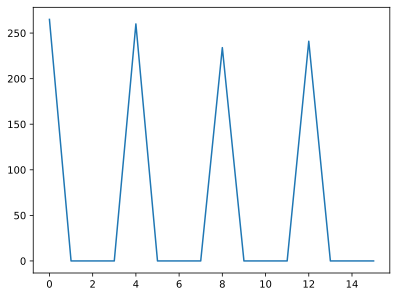

In [21]:
pts = []
for i in range(2**size_eig):
        k = nat2bs(size_eig,i)
        if k in d:
            pts.append((i,d[k]))
        else:
            pts.append((i,0))

def snd(a):
    (a1,a2) = a
    return a1
        
pts.sort(key = snd)

xs = []
ys = []
for i in range(len(pts)):
    (x,y) = pts[i]
    xs.append(x)
    ys.append(y)
plot(xs,ys)

### Q 4.3 Analysis

- What is the order $r$ of $a$ mod $N$ (here $7$ mod $30$) ?
- On the drawing, where are we supposed to see the values $\frac{s}{r}$ ? The horizontal axis is graded with integers... To what real numbers between 0 and 1 these correspond to ?
- Can you infer from the graph the value of $r$ ? Where do you see it on the graph ?
- Change a and N respectively to 20 and 29. Can you read the value $r$ ? Is it correct ?
- The drawing is not very precise... How to make it better ? Try it !
- Is it still working if you change the value of `a` and/or `N` to other values ? Beware not to use too large values for`N`... To get some inspiration, below is the list of possibilities up to 31.

**BEWARE** Make sure to only consider coprimes `a` and `N`.

In [70]:
for N in range(3,32):
    for a in range(2,N):
        if gcd(a,N) == 1:
            for p in range(1,N):
                if (a ** p) % N == 1:
                    break
            print(f"Order of {a} mod {N}: {p}")

Order of 2 mod 3: 2
Order of 3 mod 4: 2
Order of 2 mod 5: 4
Order of 3 mod 5: 4
Order of 4 mod 5: 2
Order of 5 mod 6: 2
Order of 2 mod 7: 3
Order of 3 mod 7: 6
Order of 4 mod 7: 3
Order of 5 mod 7: 6
Order of 6 mod 7: 2
Order of 3 mod 8: 2
Order of 5 mod 8: 2
Order of 7 mod 8: 2
Order of 2 mod 9: 6
Order of 4 mod 9: 3
Order of 5 mod 9: 6
Order of 7 mod 9: 3
Order of 8 mod 9: 2
Order of 3 mod 10: 4
Order of 7 mod 10: 4
Order of 9 mod 10: 2
Order of 2 mod 11: 10
Order of 3 mod 11: 5
Order of 4 mod 11: 5
Order of 5 mod 11: 5
Order of 6 mod 11: 10
Order of 7 mod 11: 10
Order of 8 mod 11: 10
Order of 9 mod 11: 5
Order of 10 mod 11: 2
Order of 5 mod 12: 2
Order of 7 mod 12: 2
Order of 11 mod 12: 2
Order of 2 mod 13: 12
Order of 3 mod 13: 3
Order of 4 mod 13: 6
Order of 5 mod 13: 4
Order of 6 mod 13: 12
Order of 7 mod 13: 12
Order of 8 mod 13: 4
Order of 9 mod 13: 3
Order of 10 mod 13: 6
Order of 11 mod 13: 12
Order of 12 mod 13: 2
Order of 3 mod 14: 6
Order of 5 mod 14: 6
Order of 9 mod 14: 